# Grid Search in REP

This notebook demonstrates tools to optimize classification model provided by __Reproducible experiment platform (REP)__ package:

* __grid search for the best classifier hyperparameters__

* __different optimization algorithms__ 

* __different scoring models__ (optimization of arbirtary figure of merit)



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Loading data 
Dataset 'magic' from UCI

In [2]:
!cd toy_datasets; wget -O magic04.data -nc --no-check-certificate https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data

File `magic04.data' already there; not retrieving.


In [3]:
import numpy, pandas
from rep.utils import train_test_split
from sklearn.metrics import roc_auc_score

columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'g']
data = pandas.read_csv('toy_datasets/magic04.data', names=columns)
labels = numpy.array(data['g'] == 'g', dtype=int)
data = data.drop('g', axis=1)

# Simple grid search example
In this example we are optimizing
* parameters of GradientBoostingClassifier
* we maximize RocAuc (= area under the ROC curve)
* using 4 threads (each time we train 4 classifiers)
* we use 3-Folding to estimate quality.
* we use only 30 trees to make examples run fast

In [4]:
import numpy
import numexpr
import pandas
from rep import utils
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc
from rep.metaml import GridOptimalSearchCV, FoldingScorer, RandomParameterOptimizer
from rep.estimators import SklearnClassifier, TMVAClassifier, XGBoostRegressor

In [5]:
# define grid parameters
grid_param = {}
grid_param['learning_rate'] = [0.2, 0.1, 0.05, 0.02, 0.01]
grid_param['max_depth'] = [2, 3, 4, 5]

# use random hyperparameter optimization algorithm 
generator = RandomParameterOptimizer(grid_param)

# define folding scorer
scorer = FoldingScorer(RocAuc(), folds=3, fold_checks=3)

In [6]:
%%time 
estimator = SklearnClassifier(GradientBoostingClassifier(n_estimators=30))
grid_finder = GridOptimalSearchCV(estimator, generator, scorer, parallel_profile='threads-4')
grid_finder.fit(data, labels)

Performing grid search in 4 threads
4 evaluations done
8 evaluations done
10 evaluations done
CPU times: user 47.2 s, sys: 772 ms, total: 48 s
Wall time: 17.5 s


## Looking at results

In [7]:
grid_finder.params_generator.print_results()

0.925:  learning_rate=0.2, max_depth=5
0.924:  learning_rate=0.2, max_depth=4
0.920:  learning_rate=0.1, max_depth=5
0.917:  learning_rate=0.2, max_depth=3
0.909:  learning_rate=0.05, max_depth=5
0.901:  learning_rate=0.05, max_depth=4
0.889:  learning_rate=0.1, max_depth=2
0.888:  learning_rate=0.01, max_depth=5
0.883:  learning_rate=0.02, max_depth=4
0.866:  learning_rate=0.02, max_depth=3


## Optimizing the parameters and threshold 
In many applications we need to optimize some binary metrics for classification (f1, BER, misclassification error), in which case we need each time after training classifier to find optimal threshold on predicted probabilities (default one is usually bad).

In this example:
* we are optimizing AMS (binary metric, that was used in Higgs competition at kaggle)
* tuning parameters of TMVA's GBDT
* using GaussianProcesses to make good guesses about next points to check

In [8]:
from rep.metaml import RegressionParameterOptimizer
from sklearn.gaussian_process import GaussianProcess
from rep.report.metrics import OptimalMetric, ams

In [9]:
%%time
# OptimalMetrics is a wrapper which is able to check all possible thresholds
# expected number of signal and background events are taken as some arbitrary numbers
optimal_ams = OptimalMetric(ams, expected_s=100, expected_b=1000)

# define grid parameters
grid_param = {'Shrinkage': [0.4, 0.2, 0.1, 0.05, 0.02, 0.01], 
              'NTrees': [5, 10, 15, 20, 25], 
              # you can pass different sets of features to be compared
              'features': [columns[:2], columns[:3], columns[:4]],
             }

# using GaussianProcesses 
generator = RegressionParameterOptimizer(grid_param, n_evaluations=10, regressor=GaussianProcess(), n_attempts=10)

# define folding scorer
scorer = FoldingScorer(optimal_ams, folds=2, fold_checks=2)

grid_finder = GridOptimalSearchCV(TMVAClassifier(method='kBDT', BoostType='Grad',), generator, scorer, parallel_profile='threads-3')
grid_finder.fit(data, labels)

Performing grid search in 3 threads
3 evaluations done
6 evaluations done
9 evaluations done
12 evaluations done
CPU times: user 8.38 s, sys: 1.67 s, total: 10.1 s
Wall time: 1min 14s


### Looking at results

In [10]:
grid_finder.generator.print_results()

4.383:  Shrinkage=0.4, NTrees=25, features=['fLength', 'fWidth', 'fSize', 'fConc']
4.307:  Shrinkage=0.2, NTrees=25, features=['fLength', 'fWidth', 'fSize', 'fConc']
4.261:  Shrinkage=0.2, NTrees=20, features=['fLength', 'fWidth', 'fSize', 'fConc']
4.253:  Shrinkage=0.4, NTrees=25, features=['fLength', 'fWidth', 'fSize']
4.172:  Shrinkage=0.2, NTrees=25, features=['fLength', 'fWidth', 'fSize']
4.123:  Shrinkage=0.2, NTrees=15, features=['fLength', 'fWidth', 'fSize', 'fConc']
4.104:  Shrinkage=0.1, NTrees=20, features=['fLength', 'fWidth', 'fSize', 'fConc']
4.064:  Shrinkage=0.1, NTrees=20, features=['fLength', 'fWidth', 'fSize']
4.059:  Shrinkage=0.2, NTrees=10, features=['fLength', 'fWidth', 'fSize', 'fConc']
4.045:  Shrinkage=0.2, NTrees=5, features=['fLength', 'fWidth', 'fSize', 'fConc']
4.041:  Shrinkage=0.1, NTrees=10, features=['fLength', 'fWidth', 'fSize', 'fConc']
3.731:  Shrinkage=0.4, NTrees=10, features=['fLength', 'fWidth']


### Let's see dynamics over time

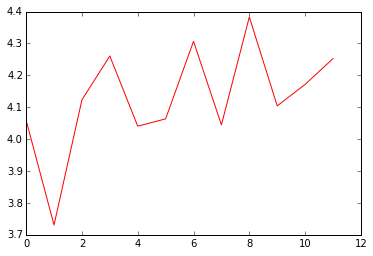

In [11]:
plot(grid_finder.generator.grid_scores_.values())

# Optimizing complex models + using custom scorer
__REP__ supports sklearn-way of combining classifiers and getting/setting their parameters.

So you can tune complex models using the same approach. 

Let's optimize 
* BaggingRegressor over XGBoost regressor, we will select appropriate parameters for both
* we will roll new scorer, which test everything on special part of dataset
* we use the same data, which will be once split into train and test (this scenario of testing is sometimes needed)
* optimizing MAE (mean absolute error)

In [12]:
from sklearn.ensemble import BaggingRegressor
from rep.estimators import XGBoostRegressor

In [13]:
from rep.utils import train_test_split
# splitting into train and test
train_data, test_data, train_labels, test_labels = train_test_split(data, labels)

In [14]:
from sklearn.metrics import mean_absolute_error
from sklearn.base import clone

class MyMAEScorer(object):
    def __init__(self, test_data, test_labels):
        self.test_data = test_data
        self.test_labels = test_labels
        
    def __call__(self, base_estimator, params, X, y, sample_weight=None):
        cl = clone(base_estimator)
        cl.set_params(**params)
        cl.fit(X, y)
        # Returning with minus, because we maximize metric
        return - mean_absolute_error(self.test_labels, cl.predict(self.test_data))

In [16]:
%%time
# define grid parameters
grid_param = {
    # parameters of sklearn Bagging
    'n_estimators': [1, 3, 5, 7], 
    'max_samples': [0.2, 0.4, 0.6, 0.8],
    # parameters of base (XGBoost)
    'base_estimator__n_estimators': [10, 20, 40], 
    'base_estimator__eta': [0.1, 0.2, 0.4, 0.6, 0.8]
}

# using Gaussian Processes 
generator = RegressionParameterOptimizer(grid_param, n_evaluations=9, regressor=GaussianProcess(), n_attempts=10)

estimator = BaggingRegressor(XGBoostRegressor(), n_estimators=10)

scorer = MyMAEScorer(test_data, test_labels)

grid_finder = GridOptimalSearchCV(estimator, generator, scorer, parallel_profile='threads-3')
grid_finder.fit(data, labels)

Performing grid search in 3 threads
3 evaluations done
6 evaluations done
9 evaluations done
CPU times: user 56.2 s, sys: 414 ms, total: 56.6 s
Wall time: 24.7 s


In [17]:
grid_finder.generator.print_results()

-0.153:  n_estimators=7, max_samples=0.6, base_estimator__n_estimators=40, base_estimator__eta=0.4
-0.154:  n_estimators=5, max_samples=0.6, base_estimator__n_estimators=40, base_estimator__eta=0.4
-0.158:  n_estimators=7, max_samples=0.4, base_estimator__n_estimators=40, base_estimator__eta=0.4
-0.161:  n_estimators=1, max_samples=0.8, base_estimator__n_estimators=40, base_estimator__eta=0.4
-0.168:  n_estimators=1, max_samples=0.8, base_estimator__n_estimators=40, base_estimator__eta=0.2
-0.184:  n_estimators=7, max_samples=0.6, base_estimator__n_estimators=20, base_estimator__eta=0.2
-0.190:  n_estimators=7, max_samples=0.2, base_estimator__n_estimators=10, base_estimator__eta=0.4
-0.231:  n_estimators=1, max_samples=0.8, base_estimator__n_estimators=20, base_estimator__eta=0.1
-0.232:  n_estimators=3, max_samples=0.8, base_estimator__n_estimators=20, base_estimator__eta=0.1


# Summary
Grid search in __REP__ extends sklearn grid search, uses optimization techniques to avoid complete search of estimator parameters. 

__REP__ has predefined scorers, metric functions, optimization techniques. Each component is replaceable and you can optimize complex models and pipelines (Folders/Bagging/Boosting and so on). 

## Structure together
* _ParameterOptimizer_ is responsible for generating new set of parameters which will be checked
  * RandomParameterOptimizer
  * AnnealingParameterOptimizer
  * SubgridParameterOptimizer
  * RegressionParameterOptimizer (this one can use any regression model, like GaussianProcesses)
  
* _Scorer_ is responsible for training and evaluating metrics
  * Folding scorer (uses metrics with __REP__ interface), uses averaging quality after kFolding
  
* _GridOptimalSearchCV_ makes all of this work together and sends tasks to IPython cluster or separate threads.


